# Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

## Autocorrelation of Signals


<br>
<a id='Info'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**General Information**
    
<ul>
<li> 
    This Notebooks repeats knowledge from <a href="./../Lab-Sheet-7.ipynb">Lab-Sheet 7</a>, with minor implementation differences, i.e. the code is written function-based to be used by the <a href="./fundamental_frequency.ipynb">Fundamental Frequency Estimation Notebook</a>.
</li>     
</ul>
</div>

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/LPC/autocorrelation.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

## Navigation

![Autocorrelation needs Correlation and is needed for Fundamental Frequency](images/flow_autocorrelation.svg)

This Lab Sheet contains several Notebooks (the blue-ish colour in the picture above indicates **this** Notebook to help with navigation):

* The Notebooks [`correlation.ipynb`](./correlation.ipynb),  [`autocorrelation.ipynb`](./autocorrelation.ipynb) and [`fundamental_frequency.ipynb`](./fundamental_frequency.ipynb)  repeat knowlege already known from lab sheet [Lab-Sheet 3](Lab-Sheet-3.ipynb) and [Lab-Sheet 7](Lab-Sheet-7.ipynb), respectively.
* The Notebook [`lpc_analysis.ipynb`](./lpc_analysis.ipynb)
* The Notebook [`lpc_synthesis.ipynb`](./lpc_synthesis.ipynb)
* The Notebook [`lpc.ipynb`](./lpc.ipynb) is the main Notebook relying an all other Notebooks and the code therein.

## Intended Learning Outcomes (ILOs)

After completing this notebook, students should be able to

- *differentiate* between correlation and autocorrelation and
- *implement* an autocorrelation function.

## Theory

In the [previous notebook](./correlation.ipynb) we have only directly correlated two signals (of the same length) and only directly correlated a signal with itself.

In general it is also very interesting and useful to know whether a signal correlates with a time-shifted version of itself.
One of the many examples for when we need this knowledge is LPC based speech signal analysis.
As a result we don't want to know the correlation between two signals $x[i]$ and $y[i]$ but the (auto-)correlation between $x[i]$ and $x[i-k]$, the time-shifted version of $x[i]$.

We define the *autocorrelation function estimate* at a time shift $k$ of the signal $x[i]$ of length $L$ as
$$\hat{r}_{xx}[k] = \frac{1}{L} \sum_{i=1}^{L}x[i]x[i+k] = \frac{1}{L} \sum_{i=1}^{L-k}x[i]x[i+k]$$
for all values of $k$ from $0$ to $L-1$, i.e., for each $k$ we correlate the non-shifted signal with a signal shifted by $k$ samples.
We observe that the first sum is not well defined as  $x[i+k]$ is unknown for $i+k>L$.
However, in these cases in general, signals are assumed to have infinitely many zeros before and after the actual data; we call this *zero-padding*.
Therefore, we can stop the sum at index $L-k$ since $y[i]$ becomes zero after that point.
The normalization must still be performed with the intended length $L$.
Hence, the right equality holds.

*Note:* Since we correlate the signal with (a shifted version of) itself it does not matter whether we shift a signal by $k$ or by $-k$.
If the second signal is shifted by $k$ relative to the first, the first is shifted by $-k$ relative to the second.
In other words, the autocorrelation is symmetric regarding $k=0$.

## Implementation

In [3]:
# We need the usual imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline

To obtain such an autocorrelation we need to perform the following steps:

1. Go through all possible values $k$ for the time shift. In our case, if $L$ is the number of samples we shift our signal by $k=0,1,\dots,L-1$.

2. For each $k$ calculate a correlation of the original signal and the shifted signal: Perform an element-wise multiplication of the overlapping parts of both signals and normalize with the total length of the signal. *Hint: This means that we cannot reuse our `correlation` function the [correlation notebook](./correlation.ipynb).*

**Task:** Implement the following function `autocorrelation_function` which takes a signal and should return the autocorrelation vector $\hat{r}_{xx}[k]$ containing the correlation value for all time shifts $k=0,1,\ldots,L-1$.

In [9]:
def autocorrelation_function(signal):
    """Return autocorrelation results for a given signal.

    We assume that the signal has 0-mean (i.e. we subtracted the signal's mean from the signal)."""

    # Obtain the number of samples
    L = len(signal)

    # An array to save the correlation results for each k=0,1,...,N-1
    r = np.zeros(L)

    # Go through all tau values
    for k in range(L):
        # Correlate the start of the original signal with the end of the shifted signal
        # Example (with L=9, k=4)
        # signal[:L-k] =     [.:.:.]:.:.
        # signal[k:]   = .:.:[.:.:.]
        r[k] = np.dot(signal[: L - k], signal[k:]) / L

    return r

## Plotting

The following code shows the result of the autocorrelation function for different signals.

In [5]:
def plot_autocorrelation(signal, title="Autocorrelation"):
    # Ensure that the signal has mean 0 and standard deviation 1
    signal = (signal - np.mean(signal)) / np.std(signal)

    # Calculate autocorrelation vector
    autocorrelation = autocorrelation_function(signal)

    # Extract position of maximum and minimum autocorrelation value (without first entry)
    tau_max_correlation = np.argmax(autocorrelation[1:]) + 1
    tau_min_correlation = np.argmin(autocorrelation[1:]) + 1

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    fig.suptitle(title)

    y_max = np.max(np.abs(signal)) * 1.1

    # Waveform plot in the left upper panel
    ax = axs[0, 0]
    ax.plot(np.arange(len(signal)), signal, marker="o", lw=0.3)
    # Axes settings
    ax.set_xlim(0, len(signal) - 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(-y_max, y_max)
    # Labels
    ax.set_title("(a) Signal $x[k]$")
    ax.set_xlabel("time $k$ in samples")

    # Results of the autocorrelation in the left lower panel
    ax = axs[1, 0]
    ax.plot(np.arange(len(autocorrelation)), autocorrelation, marker="o", lw=0.3)
    ax.plot(
        [tau_min_correlation],
        [autocorrelation[tau_min_correlation]],
        marker="v",
        markersize=12,
    )
    ax.plot(
        [tau_max_correlation],
        [autocorrelation[tau_max_correlation]],
        marker="^",
        markersize=12,
    )
    ax.axhline(autocorrelation[tau_min_correlation], color="C1", alpha=0.25)
    ax.axhline(autocorrelation[tau_max_correlation], color="C2", alpha=0.25)
    ax.annotate(
        "Maximal negative correlation: {:.2f}".format(
            autocorrelation[tau_min_correlation]
        ),
        (tau_min_correlation, autocorrelation[tau_min_correlation]),
        xytext=(tau_min_correlation, autocorrelation[tau_min_correlation] - 0.1),
        verticalalignment="top",
    )
    ax.annotate(
        "Maximal positive correlation: {:.2f}".format(
            autocorrelation[tau_max_correlation]
        ),
        (tau_max_correlation, autocorrelation[tau_max_correlation]),
        xytext=(tau_max_correlation, autocorrelation[tau_max_correlation] + 0.1),
        verticalalignment="bottom",
    )
    # Axes settings
    ax.set_xlim(0, len(autocorrelation) - 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(-1.1, 1.1)
    # Labels
    ax.set_title("(b) Autocorrelation $\hat{r}_{xx}[k]$")
    ax.set_xlabel("time-shift $k$ in samples")

    # Signal and shifted signal giving the maximal correlation in the right upper panel
    ax = axs[0, 1]
    ax.plot(
        np.arange(len(signal)) - tau_max_correlation,
        signal,
        marker="o",
        lw=0.3,
        color="C2",
        label="x[k+" + str(tau_max_correlation) + "]",
    )
    ax.plot(np.arange(len(signal)), signal, marker="o", lw=0.3, alpha=0.9, label="x[k]")
    ax.axvspan(0, len(signal) - 1 - tau_max_correlation, alpha=0.1, color="C0")
    # Axes settings
    ax.set_xlim(-max(tau_min_correlation, tau_max_correlation), len(signal) - 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(-y_max, y_max)
    # Labels
    ax.set_title(
        "(c) Maximal positive correlation: signal $x[k+"
        + str(tau_max_correlation)
        + "]$ vs. $x[k]$"
    )
    ax.set_xlabel("time $k$ in samples")
    ax.legend()

    # Signal and shifted signal giving the maximal negative correlation in the right lower panel
    ax = axs[1, 1]
    ax.plot(
        np.arange(len(signal)) - tau_min_correlation,
        signal,
        marker="o",
        lw=0.3,
        color="C1",
        label="$x[k+" + str(tau_min_correlation) + "]$",
    )
    ax.plot(np.arange(len(signal)), signal, marker="o", lw=0.3, alpha=0.9, label="x[k]")
    ax.axvspan(0, len(signal) - 1 - tau_min_correlation, alpha=0.1, color="C0")
    # Axes settings
    ax.set_xlim(-max(tau_min_correlation, tau_max_correlation), len(signal) - 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(-y_max, y_max)
    # Labels
    ax.set_title(
        "(d) Maximal negative correlation: signal $x[k+"
        + str(tau_min_correlation)
        + "]$ vs. $x[k]$"
    )
    ax.set_xlabel("time $k$ in samples")
    ax.legend()

    fig.tight_layout()

## Examples

### Autocorrelation of a sine wave

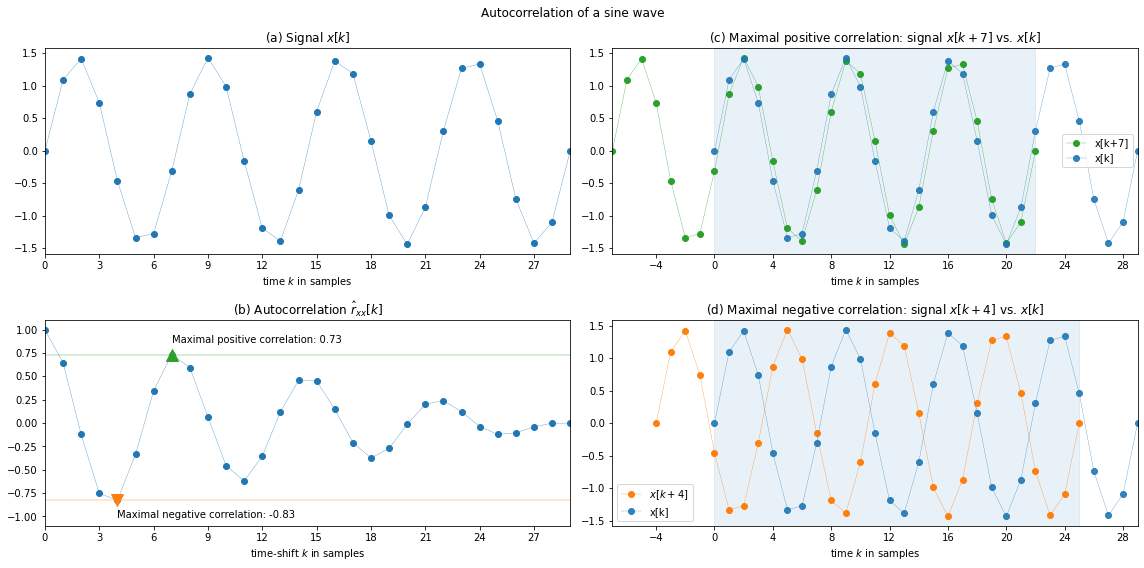

In [6]:
if __name__ == "__main__":
    sine = np.sin(np.linspace(0, 8*np.pi, 30))
    plot_autocorrelation(sine, "Autocorrelation of a sine wave")

We see here the original signal $x[k]$ in blue in the upper left panel (a). In the lower left panel (b) we see all correlation values depending on the number of samples the signal is shifted. We can see that the correlation goes towards zero the more the signal is shifted (and hence the less overlap we have). We can also see clear maxima indicating the sine wave nature.

The two panels on the right analyse the maximum (c) and minimum (d) of the autocorrelation which are marked in the same color in the autocorrelation panel (b).

We can observe that in (c) the signals overlap very well whereas in (d) they are mirrored. In both panels the shaded region shows where both signals overlap, i.e., where non-zero values for the correlation are obtained.

### Autocorrelation of white noise

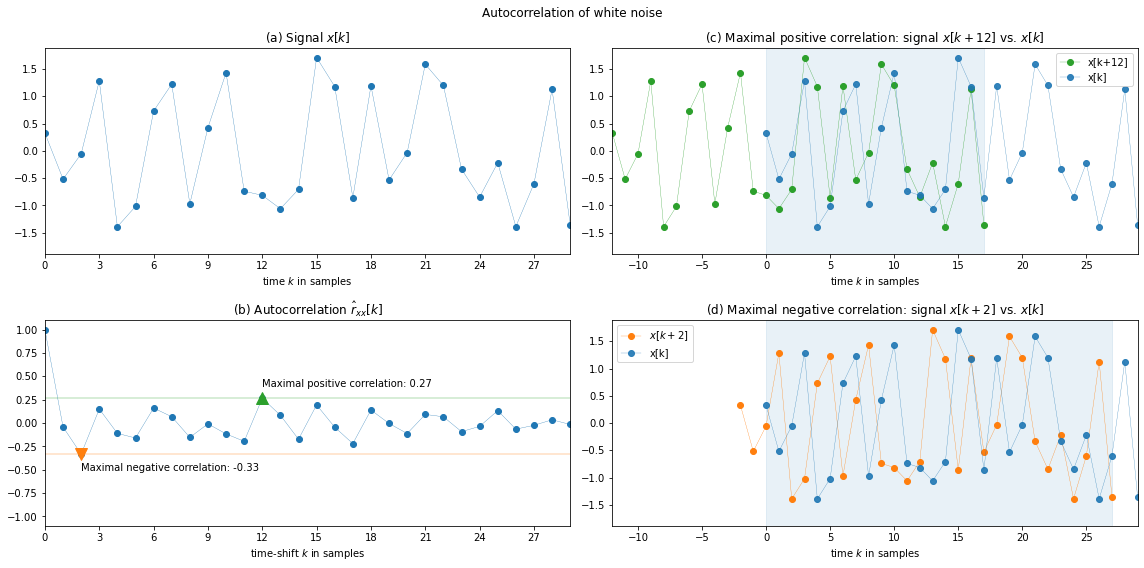

In [7]:
if __name__ == "__main__":
    np.random.seed(100)
    noise = np.random.uniform(-1, 1, size=30)
    plot_autocorrelation(noise, "Autocorrelation of white noise")

For the noise signal we can observe that, apart for no time-shift, the correlation values are all small and do not indicate any kind of repetition in the signal.

### Autocorrelation of 50% white noise with 50% sine wave

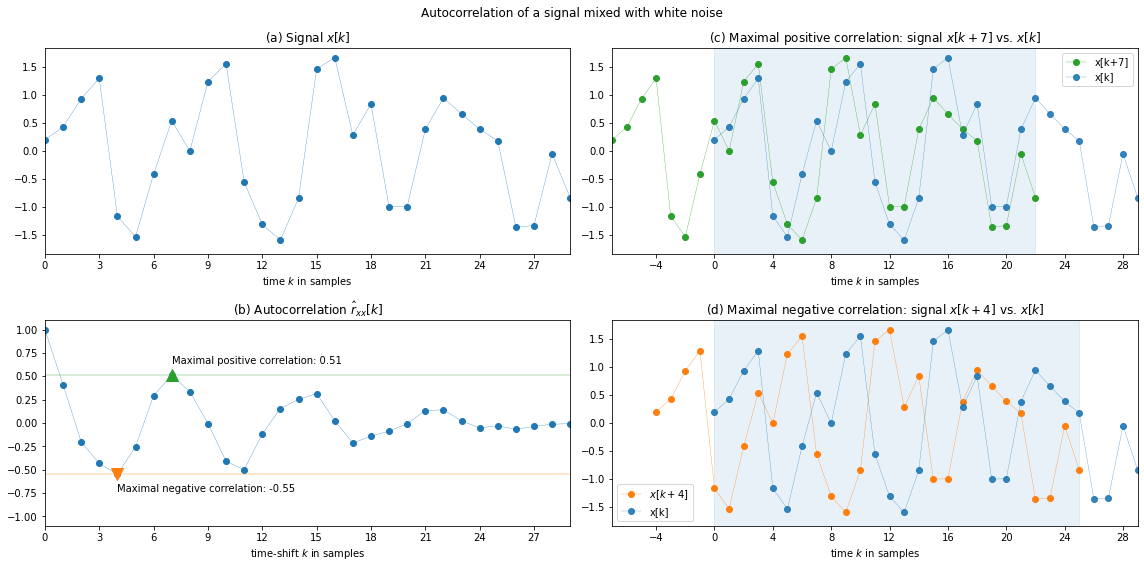

In [8]:
if __name__ == "__main__":
    # Mix 50% of a sine wave with 50% noise
    plot_autocorrelation(sine + noise, "Autocorrelation of a signal mixed with white noise")

When mixing a sine wave with one third noise we can observe that the autocorrelation still works very well and produces results similar to the ones for the situation without any noise.

## Copyright
This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 
### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/)